In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
import cv2
import os 
import numpy as np


In [2]:
img = image.load_img("dataset/train/A/0.jpg")

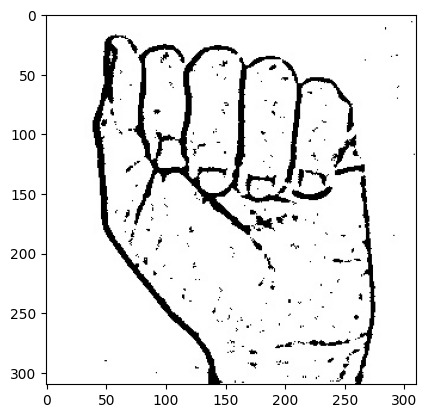

In [3]:
plt.imshow(img)

In [4]:
cv2.imread("dataset/train/A/0.jpg").shape

(310, 310, 3)

In [5]:
sz = 128
classifier = Sequential()

In [6]:
# First convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# Second convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#Third Convolution layer and pooling
classifier.add(Convolution2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

In [7]:
classifier.add(Flatten())

In [8]:
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=96, activation='relu'))
classifier.add(Dropout(0.40))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=27, activation='softmax'))

In [9]:
# Compiling the CNN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy for more than 2

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0

In [11]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
training_set = train_datagen.flow_from_directory('dataset/train',
                                                 target_size=(sz, sz),
                                                 batch_size=32,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

Found 15219 images belonging to 27 classes.


In [28]:
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(sz , sz),
                                            batch_size=32,
                                            color_mode='grayscale',
                                            class_mode='categorical') 

Found 6825 images belonging to 27 classes.


In [29]:
history=classifier.fit(
        training_set,
        steps_per_epoch=len(training_set), # No of images in training set
        epochs=5,
        validation_data=test_set,
        validation_steps=len(test_set))# No of images in test set

Epoch 1/5
476/476 [==============================] - 101s 213ms/step - loss: 0.1553 - accuracy: 0.9500 - val_loss: 0.0178 - val_accuracy: 0.9938
Epoch 2/5
476/476 [==============================] - 100s 209ms/step - loss: 0.1338 - accuracy: 0.9568 - val_loss: 0.0250 - val_accuracy: 0.9908
Epoch 3/5
476/476 [==============================] - 99s 209ms/step - loss: 0.1323 - accuracy: 0.9572 - val_loss: 0.0231 - val_accuracy: 0.9943
Epoch 4/5
476/476 [==============================] - 100s 210ms/step - loss: 0.1194 - accuracy: 0.9608 - val_loss: 0.0251 - val_accuracy: 0.9915
Epoch 5/5
476/476 [==============================] - 100s 210ms/step - loss: 0.1232 - accuracy: 0.9620 - val_loss: 0.0119 - val_accuracy: 0.9965


In [30]:

# Saving the model
model_json = classifier.to_json()
with open("model-bw.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
classifier.save_weights('model-bw.h5')
print('Weights saved')
class_names = training_set.class_indices
labels = list(class_names.keys())

with open("label.txt", "w") as label_file:
    for label in labels:
        label_file.write(label + "\n")

print('Class labels saved to label.txt')


Model Saved
Weights saved
Class labels saved to label.txt


(None, 128, 128, 1)
1/1 [==============================] - 0s 110ms/step


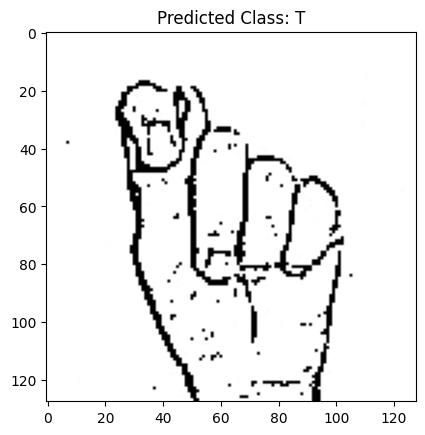

In [31]:
import os
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the saved model architecture from JSON file
model_path = "model-bw.json"
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()

# Create the model from the loaded JSON
loaded_model = model_from_json(loaded_model_json)

# Load weights into the model
loaded_model.load_weights("model-bw.h5")
print(loaded_model.input_shape)

# Compile the model (important step)
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load class names from label.txt
label_path = "label.txt"
with open(label_path, "r") as label_file:
    class_names = label_file.read().splitlines()

# Path to the image you want to predict
image_path = "dataset/test/T/108.jpg"  # Replace with the actual path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(sz, sz), color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Display the image and label
plt.imshow(img, cmap="gray")  # Use cmap="gray" for grayscale images
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()



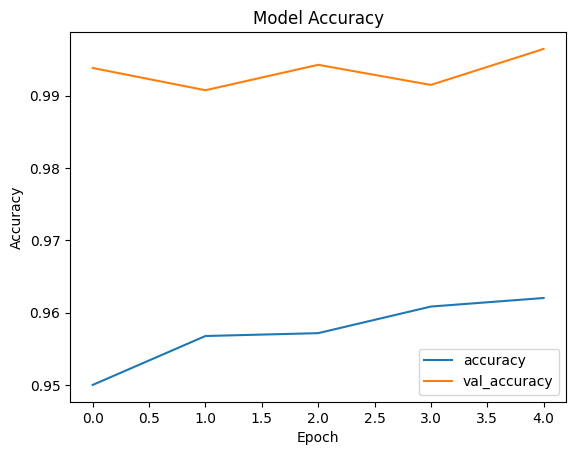

In [32]:
# Plotting accuracy graphs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


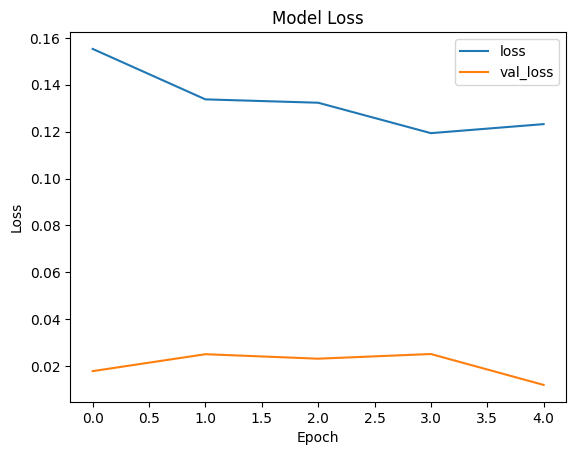

In [33]:
# Plotting loss graphs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

(None, 128, 128, 1)
214/214 [==============================] - 11s 47ms/step


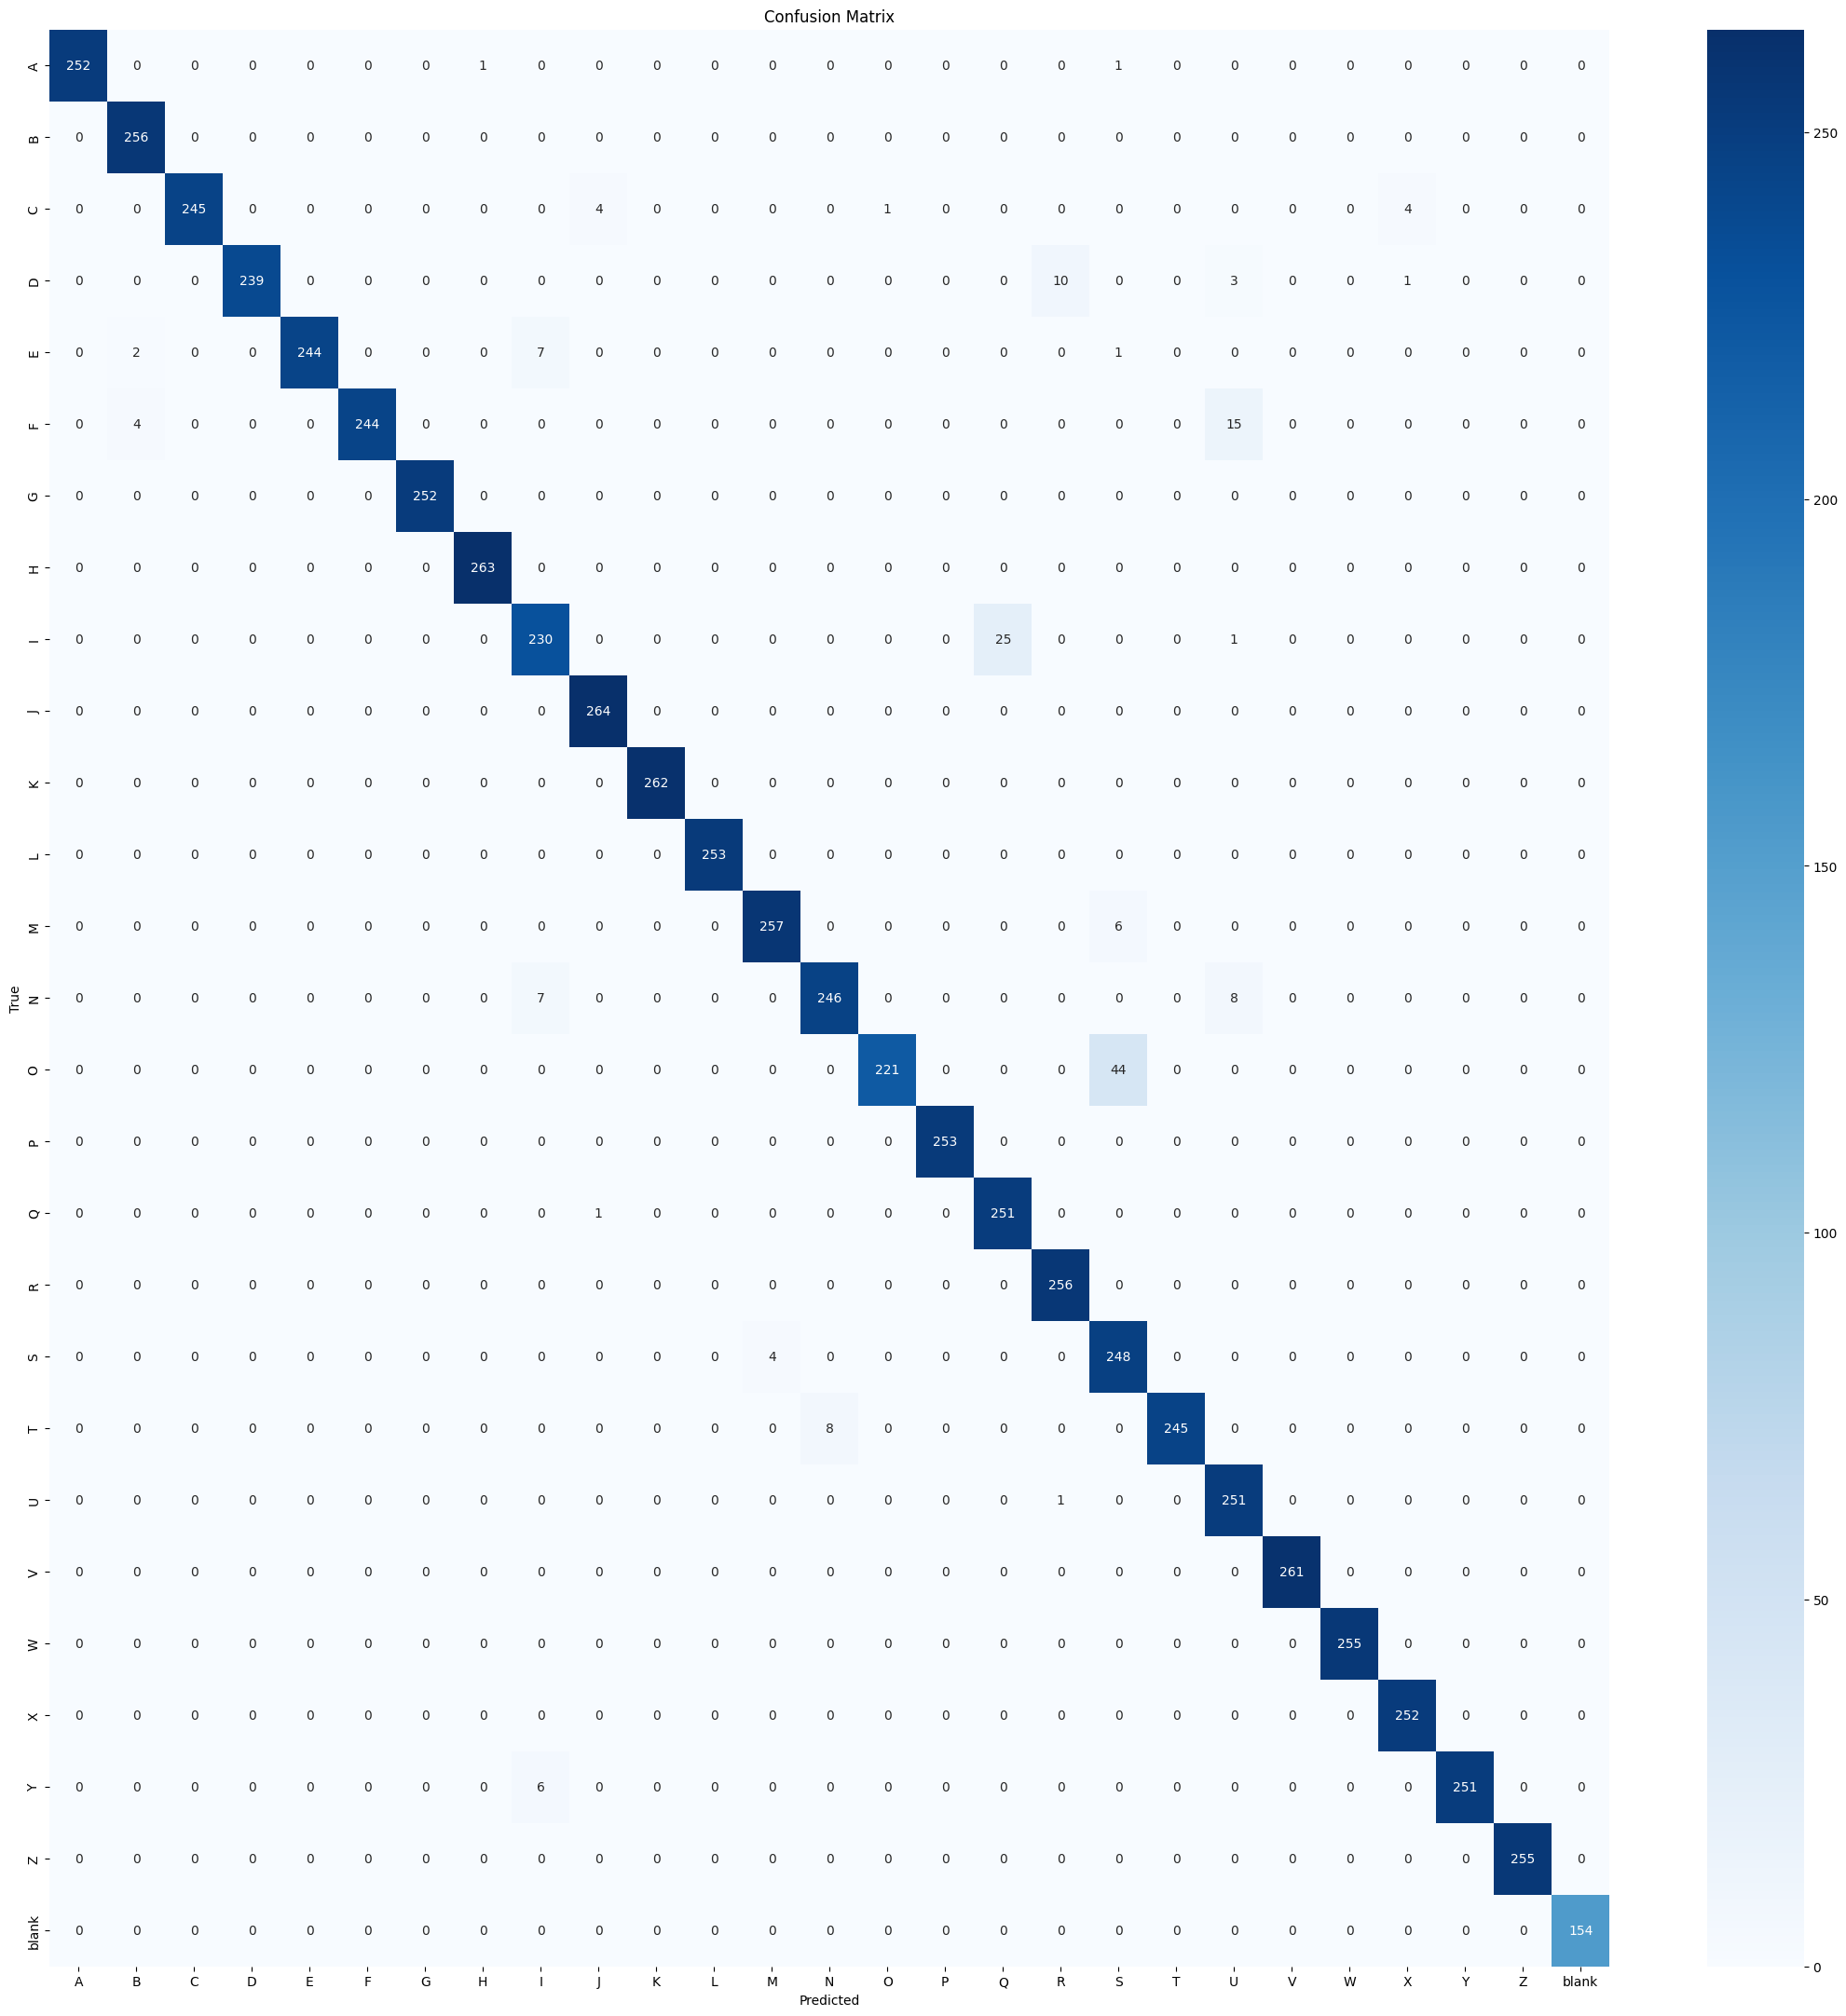

In [18]:
import os
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to load images and labels
def load_data(dataset_path, class_names):
    data = []
    labels = []
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = image.load_img(img_path, target_size=(sz, sz), color_mode="grayscale")
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0
            data.append(img_array)
            labels.append(i)
    return np.vstack(data), np.array(labels)

# Set the path to your dataset
dataset_path = "dataset/test"  # Replace with the actual path

# Load class names from label.txt
label_path = "label.txt"
with open(label_path, "r") as label_file:
    class_names = label_file.read().splitlines()

# Load the saved model architecture from JSON file
model_path = "model-bw.json"
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()

# Create the model from the loaded JSON
loaded_model = model_from_json(loaded_model_json)

# Load weights into the model
loaded_model.load_weights("model-bw.h5")
print(loaded_model.input_shape)

# Compile the model (important step)
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load test data
X_test, y_test = load_data(dataset_path, class_names)

# Make predictions
predictions = loaded_model.predict(X_test)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_class_indices)

# Display confusion matrix as a heatmap
plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
